1. With Tree / without tree regression performance: tree performs better
2. Bayesian Tensor Regression without tree / tree regression method: tree performs better
3. leaf node performance detection: 
   (1) on leaf nodes, which leaf contributs to the most error, which least, under which CP/Tucker/Mean method
   (2) enlarge node model space to Bayesian Reg
4. with 3. (2), we can compare if Bayesian Tensor on leaf nodes is better than Bayesian Tensor on root to prove the role of tree structure

In [12]:
# sliced 3D real image
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from concurrent.futures import ProcessPoolExecutor
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorly as tl

#Debugging import
import importlib
var = 'TensorDecisionTreeRegressorP' #the published version of code
package = importlib.import_module(var)
for name, value in package.__dict__.items():
    if not name.startswith("__"):
        globals()[name] = value

from TensorDecisionTreeRegressorP import *

import os
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.measure import block_reduce

In [2]:
import os
import pandas as pd
import numpy as np
import nibabel as nib

# Load the CSV file containing PTID and target variable
csv_file = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/ADNIData.csv'
df = pd.read_csv(csv_file)

# Extract PTID and target values from the DataFrame
ptid_csv = df['PTID'].values
y_variable = df['ADAS11'].values

# Directory containing the image files
directory = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/3D-Images/bl'

# Initialize lists for storing matched images and corresponding y values
matched_images = []
matched_y_values = []

# Loop through the image files and match by PTID
for filename in os.listdir(directory):
    if filename.endswith('.nii.gz'):
        # Extract PTID from the filename (e.g., '002_S_0295.nii.gz' -> '002_S_0295')
        ptid_image = filename.split('.')[0]  # Keep the '002_S_0295' format with underscores
        
        # Find the index of this PTID in the CSV data
        if ptid_image in ptid_csv:
            index = np.where(ptid_csv == ptid_image)[0][0]  # Get the index of the matching PTID
            y_value = y_variable[index]  # Get the corresponding target value

            # Skip if the corresponding y_value is NaN
            if np.isnan(y_value):
                print(f"Skipping PTID '{ptid_image}' because y_value is NaN.")
                continue

            # Load the image
            file_path = os.path.join(directory, filename)
            img = nib.load(file_path)
            data = img.get_fdata()

            # Append the image data and the corresponding y_value to the lists
            matched_images.append(data)
            matched_y_values.append(y_value)
        else:
            print(f"PTID '{ptid_image}' not found in the CSV file.")

# Convert the matched images and y values into arrays
if matched_images:
    image_tensor = np.stack(matched_images, axis=0)
    y_variable = np.array(matched_y_values)
    print(f"Aligned image tensor shape: {image_tensor.shape}")
    print(f"Aligned y variable shape: {y_variable.shape}")
else:
    print("No images matched.")

Skipping PTID '013_S_0699' because y_value is NaN.
Aligned image tensor shape: (817, 48, 48, 48)
Aligned y variable shape: (817,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=2, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .1
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(571, 48, 48, 48) (571,)
mean train RSE:  0.778086044415101
CP train RSE:  4.1324820752518344e-05
Tucker train RSE:  2.0945277689026657e-05
mean test RSE:  0.7922011889662797
CP test RSE:  3.8595730667983386
Tucker test RSE:  3.4009230710049367


In [5]:
model.print_tree()

  if X[:, 32 , 19 , 34 ] <=  3.8721486171364994
   if X[:, 28 , 20 , 18 ] <=  2.165013522178203
     has  0  child nodes, and  93  samples.
   else: # if X[:, 28 , 20 , 18 ] >  2.165013522178203
     has  0  child nodes, and  129  samples.
  else: # if X[:, 32 , 19 , 34 ] >  3.8721486171364994
   if X[:, 32 , 26 , 37 ] <=  4.602050602265279
     has  0  child nodes, and  118  samples.
   else: # if X[:, 32 , 26 , 37 ] >  4.602050602265279
     has  0  child nodes, and  231  samples.


In [6]:
model  =  TensorDecisionTreeRegressor(max_depth=0, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .1
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

mean train RSE:  1.0
CP train RSE:  0.06248065930336527
Tucker train RSE:  0.046643491341685446
mean test RSE:  1.00076877504258
CP test RSE:  4.17516388877428
Tucker test RSE:  4.014575440583579


Above is comparison between regression at root and regression using tree. Tree structure does improve performance and better than plain CP/Tucker/Mean regression.

In [9]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.linalg import cholesky, inv
import math
import time
from functools import reduce
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from scipy.special import gammaln, logsumexp
from sklearn.linear_model import LassoCV
import itertools
from scipy.linalg import cho_factor, cho_solve
from scipy.stats import geninvgauss
def getouter_list(bet):
    d = len(bet)
    if d == 1:
        return bet[0]
    elif d == 2:
        return np.outer(bet[0], bet[1]).reshape(bet[0].shape + bet[1].shape)
    else:
        return np.outer(getouter_list(bet[:-1]), bet[-1]).reshape(getouter_list(bet[:-1]).shape + bet[-1].shape)

def getmean(X, beta, rank, rank_exclude=None):
    if rank_exclude is None:
        rank_exclude = []

    idx = [i for i in range(rank) if i not in rank_exclude]
    B_list = [getouter_list([beta_elem[r, :] for beta_elem in beta]) for r in idx]
    B = reduce(lambda x, y: x + y, B_list)
    def compute_sum(xx, bb):
        return np.sum(xx * bb)
    mu_B = np.array([compute_sum(xx, B) for xx in X])
    return mu_B

def logsum(lx):
    max_lx = np.max(lx)
    return max_lx + np.log(np.sum(np.exp(lx - max_lx)))

def TP_rankR(X_allr):
    R = X_allr[0].shape[1] if len(X_allr[0].shape) > 1 else None
    if R is None:
        return getouter_list(X_allr)
    else:
        dims = [x.shape[0] for x in X_allr]
        Y = np.zeros(dims)
        for r in range(R):
            outer_results = [x[:, r] for x in X_allr]
            Y += getouter_list(outer_results)
        return Y

def getBeta_mcmc(beta_store):
    nsweep = len(beta_store)
    d = len(beta_store[0])
    rank = beta_store[0][0].shape[0]
    p = [beta_store[0][x].shape[1] for x in range(d)]
    Beta_mcmc = np.zeros((nsweep, np.prod(p)))
    
    for i in range(nsweep):
        coef = np.zeros(np.prod(p))
        for r in range(rank):
            outer_list = [beta_store[i][x][r, :] for x in range(d)]
            coef += getouter_list(outer_list).flatten()
        Beta_mcmc[i, :] = coef    
    return Beta_mcmc

####main function####
def tensor_reg(z_train, x_train, y_train, a_lam, b_lam, phi_alpha, nsweep=1e3, rank=5, burn=0.30,
               nskip=3, scale=True, plot=False):
    
    
    n = len(y_train)
    p = x_train.shape[1:]
    d = len(x_train.shape)-1
    pgamma = z_train.shape[1]
    

    #### standarize ####
    my = np.mean(y_train)
    sy = np.std(y_train, ddof=1) if scale else 1
    if scale:
        obs = (y_train - my) / sy
    else:
        obs = y_train
    if scale:
        mz = np.mean(z_train, axis=0)
        sz = np.array([np.max(z_train[:, i]) - np.min(z_train[:, i]) for i in range(pgamma)])
        sz[sz==0] = 1
        Zt = np.zeros_like(z_train, dtype=float)
        for jj in range(pgamma):
            Zt[:,jj] = (z_train[:,jj] - mz[jj]) / sz[jj] 
    
        Xt = np.zeros_like(x_train, dtype=float)
        mx = np.mean(x_train, axis=0)
        def range_diff(z):
            return np.nanmax(z) - np.nanmin(z)
        sx = np.apply_along_axis(range_diff, axis=0, arr=x_train)
        sx[sx == 0] <- 1
   
        if d == 2:
            for jj in range(n):
                Xt[jj,:,:] = (x_train[jj,:,:] - mx) / sx
        elif d == 3:
            for jj in range(n):
                Xt[jj,:,:,:] = (x_train[jj,:,:,:] - mx) / sx
 
    else:
        Zt = z_train
        Xt = x_train








    

    x_train_nona = Xt
    #### MCMC setup ####
    ZZ = np.dot(Zt.T, Zt)
    vecXt = Xt.reshape(n, np.prod(p))
    vecXt = np.hstack((z_train, vecXt))


    las = LassoCV(cv=5).fit(vecXt, y_train)
    beta_init = las.coef_
    gam = beta_init[0:pgamma]

    ##hyper-par initialize
    a_lam = None; b_lam = None; phi_alpha = None
    if a_lam is None:
        a_lam = [3.0] * rank
        a_lam = np.array(a_lam)
    if b_lam is None:
        b_lam = a_lam**(1/(2*d))
    if phi_alpha is None:
        phi_alpha = np.array([1/rank]*rank)
    phi_a0 = np.sum(phi_alpha)
    a_vphi = phi_a0
    b_vphi = phi_alpha[1] * rank**(1/d)
    c0 = 0
    s0 = 1; a_t = 2_5/2; b_t = 2.5/2 * s0**2

    ##fix randomness for now
    tau2  = 1 / np.random.gamma(size = 1, shape = a_t, scale=1/b_t)
    #tau2 = 2
    phi = np.random.dirichlet(phi_alpha, size = 1)
    varphi = np.random.gamma(size = 1, shape = a_vphi, scale=1/b_vphi)
    #varphi = 0.5
    tau_r = phi * varphi
    # Define the flatten function
    def flatten(nested_list):
        return [item for sublist in nested_list for item in sublist]
    tau_r = flatten(tau_r)
    
    lambda_ = np.array([1.5]*rank*d).reshape((rank, d))
    omega = [None]*d
    for x in range(d):
        omega[x] = np.random.exponential(scale=.5*(a_lam[1]/b_lam[1]), size=(rank,p[x]))

    beta = [None]*d
    for x in range(d):
        beta[x] = np.random.normal(size = (rank,p[x]))

    ##initialize tensor margins
    alpha_store = [None]*nsweep
    c0_store = [None]*nsweep
    gam_store = np.array([None]*nsweep*pgamma).reshape(nsweep,pgamma)
    tau2_store = [None]*nsweep
    phi_store = np.array([None]*nsweep*rank).reshape(nsweep,rank)
    phi_store
    varphi_store = np.array([None]*nsweep*rank).reshape(-1,1)
    varphi_store
    beta_store = [[None]*d]*nsweep
    for x in range(nsweep):
        for y in range(d):
            beta_store[x][y] = np.array([None]*rank*p[y]).reshape(rank,p[y])
    beta_store
    omega_store = [[None]*d]*nsweep
    for x in range(nsweep):
        for y in range(d):
            omega_store[x][y] = np.array([None]*rank*p[y]).reshape(rank,p[y])
    lambda_store = np.array([None]*nsweep*rank*d).reshape(nsweep,rank, d)
    #hyppar_store = np.array([None]*nsweep*rank*d).reshape(nsweep,rank, 2)
    hyppar_store = np.zeros((nsweep, rank, 2))

    alam_seq = np.linspace(2.1, d + 1, num=5)
    zeta_max = np.ceil(10 * rank**(1 / (2 * d)) / 2) / 10
    zeta_seq = np.linspace(0.5, zeta_max, num=5)
    param_grid = list(itertools.product(alam_seq, zeta_seq))
    par_grid = pd.DataFrame(param_grid, columns=['alam', 'zeta'])
    alam_seq = np.linspace(2.1, d + 1, num=5)
    zeta_max = np.ceil(10 * rank**(1 / (2 * d)) / 2) / 10
    zeta_seq = np.linspace(0.5, zeta_max, num=5)
    alam_grid, zeta_grid = np.meshgrid(alam_seq, zeta_seq)
    par_grid = pd.DataFrame({
        'alam': alam_grid.flatten(),
        'zeta': zeta_grid.flatten()
    })
    par_grid = par_grid.values
    alpha_grid = np.linspace(rank**(-d), rank**(-0.1), num=10)
    M=20
    score_store = np.array([None]*nsweep*len(alpha_grid)).reshape(nsweep,len(alpha_grid))

    #### MCMC run ####
    start_time = time.time()
    for sweep in range(nsweep):
        tens_mean = getmean(x_train_nona, beta, rank)
        Cjr = np.zeros((d, rank))
        for rr in range(rank):
            for jj in range(d):
                bb = np.sum(np.abs(beta[jj][rr, :]))
                Cjr[jj, rr] = bb / np.sqrt(tau_r[rr])
                #print("Cjr[jj, rr]: ", Cjr[jj, rr])
        def mfun(z, rank, p, Cjr):
            o = [gammaln(z[0] + p[x]) - gammaln(z[0]) + z[0] * math.log(z[1] * z[0]) - (z[0] + p[x]) * math.log(z[1] * z[0] + Cjr[x][rank]) for x in range(d)]
            return sum(o)
        
        ll = np.zeros((par_grid.shape[0], rank))
        for rr in range(rank):
            for z in range(par_grid.shape[0]):
                result = mfun(par_grid[z], rr, p, Cjr)
                ll[z, rr] = result
        




        par_wt = np.apply_along_axis(lambda z: np.exp(z - logsum(z)), axis=0, arr=ll)
        #par_wt = np.apply_along_axis(lambda z: np.exp(z - np.log(np.sum(z))), axis=0, arr=ll)
        par_wt = np.nan_to_num(par_wt, nan=0.0, posinf=0.0, neginf=0.0)
        for i in range(par_wt.shape[1]):
            par_wt[:,i] = par_wt[:,i]/np.sum(par_wt[:,i])
        par_wt = np.nan_to_num(par_wt, nan=0.0, posinf=0.0, neginf=0.0)
        # Convert the cleaned NumPy array back to a list
        #cleaned_list = cleaned_array.tolist()
        #print("par_wt:", sum(par_wt)) 





        indices = np.arange(par_grid.shape[0])
        ixx = np.zeros(par_wt.shape[1], dtype=int)
        for i in range(par_wt.shape[1]):
            ixx[i] = np.random.choice(indices, size=1, p=par_wt[:, i])[0]
        
        for rr in range(rank):
            a_lam[rr] = par_grid[ixx[rr], 0]
            b_lam[rr] = par_grid[ixx[rr], 1] * a_lam[rr]
        np.set_printoptions(precision=10, suppress=False)

        ##update gamma
        diag_pgamma = np.diag(np.ones(pgamma))
        cho_factor_matrix = cho_factor(diag_pgamma + ZZ / tau2)
        Sig_g = cho_solve(cho_factor_matrix, np.eye(pgamma))
        mu_g = np.dot(Sig_g, np.dot(Zt.T, (obs - c0 - tens_mean)) / tau2)
        rnorm_pgamma = np.random.normal(size=pgamma)
        gam = mu_g + np.dot(np.linalg.cholesky(Sig_g), rnorm_pgamma)

        ## update alpha (intercept)
        pred_mean = np.dot(Zt, gam)
        mu_c0 = np.mean(obs - pred_mean - tens_mean)
        c0 = np.random.normal(loc=mu_c0, scale=np.sqrt(tau2 / n))
        
        ## update tau2
        a_tau = a_t + n / 2
        b_tau = b_t + 0.5 * np.sum((obs - c0 - pred_mean - tens_mean)**2)
        tau2 = 1 / stats.gamma.rvs(a=a_tau, scale=1/b_tau)

        ## update (alpha, phi, varphi)
        def draw_phi_tau(alpha_grid):
            length = len(alpha_grid)

            # Precompute Cr matrix
            Cr = np.array([
                [
                    np.dot(beta[jj][rr, :], np.dot(np.diag(1 / omega[jj][rr, :]), beta[jj][rr, :]))
                    for rr in range(rank)
                ]
                for jj in range(d)
            ])

            def score_fn(phi_alpha, phi_s, varphi_s, Cstat):
                def ldirdens(v, a):
                    c1 = gammaln(np.sum(a))
                    c2 = np.sum(gammaln(a))
                    return (c1 - c2) + np.sum((a - 1) * np.log(np.maximum(v, 1e-10)))  

                ldir = np.apply_along_axis(ldirdens, 1, phi_s, a=phi_alpha)

                lvarphi = stats.gamma.logpdf(varphi_s, a=np.sum(phi_alpha), scale=1/b_vphi)
                
                dnorm_log = -np.sum(Cstat, axis=1) / (2 * np.maximum(varphi_s, 1e-10)) 
                dnorm_log -= (np.sum(p) / 2) * np.array([np.sum(np.log(np.maximum(varphi_s[ii] * phi_s[ii, :], 1e-10))) for ii in range(len(varphi_s))])  # Avoid log(0)
                
                return dnorm_log + ldir + lvarphi

            if length > 1:
                phi = np.zeros((M * length, rank))
                varphi = np.zeros((M * length, 1))
                Cstat = np.zeros((M * length, rank))
                
                for jj in range(length):
                    m_phialpha = np.full(rank, alpha_grid[jj])
                    m_phia0 = np.sum(m_phialpha)
                    m_avphi = m_phia0

                    # Draw phi
                    Cr1 = np.sum(Cr, axis=0)
                    phi_a = np.array([geninvgauss.rvs(m_phialpha[rr] - np.sum(p)/2, Cr1[rr], scale=2 * b_vphi, size=M) for rr in range(rank)]).T
                    phi_a = np.apply_along_axis(lambda z: z / np.sum(z), 1, phi_a)

                    # Draw varphi
                    Cr2 = np.apply_along_axis(lambda z: Cr1 / np.maximum(z, 1e-10), 1, phi_a)  # Avoid division by zero
                    varphi_a = np.array([geninvgauss.rvs(m_avphi - rank * np.sum(p)/2, 2 * b_vphi, scale=np.sum(z)) for z in Cr2]).flatten()

                    phi[jj * M:(jj + 1) * M, :] = phi_a
                    varphi[jj * M:(jj + 1) * M, 0] = varphi_a
                    Cstat[jj * M:(jj + 1) * M, :] = Cr2

                scores = [score_fn(np.full(rank, z), phi, varphi, Cstat) for z in alpha_grid]
                scores = np.array(scores)
                lmax = np.max(scores)
                normalized_scores = np.array([np.mean(np.exp(score - lmax)) for score in scores])
                normalized_scores /= np.sum(normalized_scores)  # Ensure scores sum to 1
            else:
                m_phialpha = np.full(rank, alpha_grid[0])
                m_phia0 = np.sum(m_phialpha)
                m_avphi = m_phia0

                Cr1 = np.sum(Cr, axis=0)

                # Draw phi
                phi = np.array([geninvgauss.rvs(m_phialpha[rr] - np.sum(p) / 2, 2 * b_vphi, scale=Cr1[rr], size=1) for rr in range(rank)]).flatten()
                phi = phi / np.sum(phi)

                # Draw varphi
                Cr2 = Cr1 / np.maximum(phi, 1e-10)  # Avoid division by zero
                varphi = geninvgauss.rvs(m_avphi - rank * np.sum(p) / 2, 2 * b_vphi, scale=np.sum(Cr2), size=1)

                scores = score_fn(m_phialpha, np.array([phi]), np.array([varphi]), np.array([Cr2]))
                scores = np.array([scores])
                lmax = np.max(scores)
                normalized_scores = np.array([np.mean(np.exp(scores - lmax))])
                normalized_scores /= np.sum(normalized_scores)  # Ensure scores sum to 1

            return {'phi': phi, 'varphi': varphi, 'scores': normalized_scores}
        ## sample astar
        o = draw_phi_tau(alpha_grid)
        scores = o['scores']
        normalized_scores = scores / np.sum(scores)
        astar = np.random.choice(alpha_grid, size=1, p=normalized_scores)
        score_store[sweep, :] = normalized_scores

        # Sample (phi, varphi) based on astar
        o = draw_phi_tau(astar)
        phi = o['phi']
        varphi = o['varphi']

        # Calculate tau.r
        tau_r = varphi * phi
        #print("tau_r: ", tau_r)
        # Define phi.alpha, phi.a0, and a.vphi
        phi_alpha = np.full(rank, astar)
        phi_a0 = np.sum(phi_alpha)
        a_vphi = phi_a0

        ## update rank specific params
        lambda_ = np.zeros((rank, len(beta)))
        for r in range(rank):
            for j in range(d):
                tens_mu_r = getmean(x_train_nona, beta, rank, [r])
                    
                betj = getouter_list([beta_elem[r, :] for k, beta_elem in enumerate(beta) if k != j])
                    
                H = np.full((n, p[j]), np.nan)
                for i in range(n):
                    if d == 2:
                        if j == 0:
                            H[i, :] = [np.sum(x_train_nona[i, k, :] * betj) for k in range(p[j])]
                        elif j == 1:
                                H[i, :] = [np.sum(x_train_nona[i, :, k] * betj) for k in range(p[j])]
                    elif d == 3:
                        if j == 0:
                            H[i, :] = [np.sum(x_train_nona[i, k, :, :] * betj) for k in range(p[j])]
                        elif j == 1:
                            H[i, :] = [np.sum(x_train_nona[i, :, k, :] * betj) for k in range(p[j])]
                        elif j == 2:
                            H[i, :] = [np.sum(x_train_nona[i, :, :, k] * betj) for k in range(p[j])]
                #print("H: ", H)
                HH = np.dot(H.T, H)
                #print("HH: ", HH)
                diag_elements = 1 / omega[j][r, :] / tau_r[r]
                diag_matrix = np.diag(diag_elements)
                #print("HH / tau2 + diag_matrix: ", HH / tau2 + diag_matrix)
                chol_matrix = cholesky(HH / tau2 + diag_matrix)
                K = inv(chol_matrix.T @ chol_matrix)
                #K = inv(chol_matrix)
                #print("K:", K)
                
                ##update betas
                mm = obs - c0 - pred_mean - tens_mu_r
                bet_mu_jr = K @ ((H.T/tau2)@ mm)
                chol_K = cholesky(K, lower=True)
                beta[j][r, :] = bet_mu_jr + chol_K @ np.random.randn(p[j])

                ## update lambda.jr
                shape = a_lam[r] + p[j]
                rate = b_lam[r] + np.sum(np.abs(beta[j][r, :])) / np.sqrt(tau_r[r]) 
                lambda_[r, j] = np.random.gamma(shape, 1.0 / rate)
                ## update omega.jr
                omega[j][r, :] = [geninvgauss.rvs(0.5, beta[j][r, kk]**2 / tau_r[r], scale=lambda_[r, j]**2) for kk in range(p[j])]
        
        ## store params
        tau2_store[sweep] = tau2
        c0_store[sweep] = c0
        if z_train is not None:
            gam_store[sweep, :] = gam
        else:
            gam_store[sweep] = gam
        alpha_store[sweep] = astar
        phi_store[sweep, :] = phi
        varphi_store[sweep, :] = varphi
        beta_store[sweep] = beta
        omega_store[sweep] = omega
        lambda_store[sweep, :, :] = lambda_
        for rr in range(rank):
            hyppar_store[sweep, rr, :] = [a_lam[rr], b_lam[rr]]


        
        
        #if sweep % 5 == 0:
            #print(f"{sweep}, tau2: {tau2 * sy**2:.3f}, (alpha, a.lam, b.lam): {astar:.3f}, {a_lam[r]:.3f}, {b_lam[r]:.3f}")
    
    # Example time-consuming operation
    time.sleep(0.01)
    end_time = time.time()
    elapsed_time = abs(end_time - start_time)
    print('Time out:', elapsed_time)

    out = {
    "nsweep": nsweep,
    "rank": rank,
    "p": p,
    "d": d,
    "par_grid": par_grid,
    "alpha_grid": alpha_grid,
    "my": my,
    "sy": sy,
    "mz": mz,
    "sz": sz,
    "mx": mx,
    "sx": sx,
    "Zt": Zt,
    "Xt": Xt,
    "obs": obs,
    "a_t": a_t,
    "b_t": b_t,
    "tau2_store": tau2_store,
    "c0_store": c0_store,
    "gam_store": gam_store,
    "alpha_store": alpha_store,
    "beta_store": beta_store,
    "phi_store": phi_store,
    "varphi_store": varphi_store,
    "omega_store": omega_store,
    "lambda_store": lambda_store,
    "hyppar_store": hyppar_store,
    "score_store": score_store,
    "time": elapsed_time
    }
    return out

In [11]:
z = np.zeros((817, 1))
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(image_tensor, y_variable, z, test_size=0.2, random_state=42)

# X_coarsen_shape = (1,4,4,4)
# X_coarsen_func = np.mean
# X_train_c = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
# X_test_c = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
# X_train_c = X_train_c + np.random.randn(*X_train_c.shape) * 1e-3
X_train = X_train + np.random.randn(*X_train.shape) * 1e-4
nsweep = 1000
rank = 6
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing
out = tensor_reg(z_train=z_train.reshape(len(z_train),1), x_train = X_train, y_train = y_train, nsweep = nsweep, rank = rank, burn = burn, nskip = nskip, scale=True, a_lam= None, b_lam=None, phi_alpha=None, plot=True)

# Compute Beta_mcmc
Beta_mcmc = getBeta_mcmc(out['beta_store'])
# Compute Beta_est
p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]

Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

RuntimeError: Not a single random variate could be generated in 50000 attempts. Sampling does not appear to work for the provided parameters.

In [23]:
z = np.zeros((817, 1))
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(image_tensor, y_variable, z, test_size=0.2, random_state=42)

X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.mean
X_train_c = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
X_train_c = X_train_c + np.random.randn(*X_train_c.shape) * 1e-3
# X_train = X_train + np.random.randn(*X_train.shape) * 1e-4
nsweep = 4000
rank = 6
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing
out = tensor_reg(z_train=z_train.reshape(len(z_train),1), x_train = X_train_c, y_train = y_train, nsweep = nsweep, rank = rank, burn = burn, nskip = nskip, scale=True, a_lam= None, b_lam=None, phi_alpha=None, plot=True)

# Compute Beta_mcmc
Beta_mcmc = getBeta_mcmc(out['beta_store'])
# Compute Beta_est
p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]

Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

Time out: 2663.132232904434


In [24]:
err = 0
for i in range(X_train.shape[0]):
    err += (np.tensordot(X_train_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_train[i])**2
mse = err/X_train_c.shape[0]
rmse = mse/np.var(y_train)
print("training RMSE:", rmse)

training RMSE: 11.630063430733234


In [25]:
err = 0
for i in range(X_test.shape[0]):
    err += (np.tensordot(X_test_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_train[i])**2
mse = err/X_test_c.shape[0]
rmse = mse/np.var(y_test)
print("testing RMSE:", rmse)

testing RMSE: 11.56750278099473


In [61]:
import numpy as np

# Assuming X_train is a 4D array with shape (num_samples, dim_x, dim_y, dim_z)
# Initialize separate lists to store indices for each case
filtered_indices_case1 = []
filtered_indices_case2 = []
filtered_indices_case3 = []
filtered_indices_case4 = []

for i in range(X_train.shape[0]):
    # Check the conditions for each sample
    if X_train[i, 32, 19, 34] <= 3.8721486171364994:
        if X_train[i, 28, 20, 18] <= 2.165013522178203:
            # Case 1: Condition met for 93 samples
            filtered_indices_case1.append(i)
        else:
            # Case 2: Condition met for 129 samples
            filtered_indices_case2.append(i)
    else:
        if X_train[i, 32, 26, 37] <= 4.602050602265279:
            # Case 3: Condition met for 118 samples
            filtered_indices_case3.append(i)
        else:
            # Case 4: Condition met for 231 samples
            filtered_indices_case4.append(i)

# Use the filtered indices to create new arrays for each case
filtered_X_train_case1 = X_train[filtered_indices_case1]
filtered_X_train_case2 = X_train[filtered_indices_case2]
filtered_X_train_case3 = X_train[filtered_indices_case3]
filtered_X_train_case4 = X_train[filtered_indices_case4]
import numpy as np

# Assuming X_train is a 4D array with shape (num_samples, dim_x, dim_y, dim_z)
# Initialize separate lists to store indices for each case
filtered_indices_case1_test = []
filtered_indices_case2_test = []
filtered_indices_case3_test = []
filtered_indices_case4_test = []

for i in range(X_test.shape[0]):
    # Check the conditions for each sample
    if X_test[i, 32, 19, 34] <= 3.8721486171364994:
        if X_test[i, 28, 20, 18] <= 2.165013522178203:
            # Case 1: Condition met for 93 samples
            filtered_indices_case1_test.append(i)
        else:
            # Case 2: Condition met for 129 samples
            filtered_indices_case2_test.append(i)
    else:
        if X_test[i, 32, 26, 37] <= 4.602050602265279:
            # Case 3: Condition met for 118 samples
            filtered_indices_case3_test.append(i)
        else:
            # Case 4: Condition met for 231 samples
            filtered_indices_case4_test.append(i)

# Use the filtered indices to create new arrays for each case
filtered_X_test_case1 = X_test[filtered_indices_case1_test]
filtered_X_test_case2 = X_test[filtered_indices_case2_test]
filtered_X_test_case3 = X_test[filtered_indices_case3_test]
filtered_X_test_case4 = X_test[filtered_indices_case4_test]
# Display the shapes of the filtered datasets for each case
print("Filtered X_train Case 1 shape:", filtered_X_train_case1.shape)
print("Filtered X_train Case 2 shape:", filtered_X_train_case2.shape)
print("Filtered X_train Case 3 shape:", filtered_X_train_case3.shape)
print("Filtered X_train Case 4 shape:", filtered_X_train_case4.shape)

print("Filtered X_test Case 1 shape:", filtered_X_test_case1.shape)
print("Filtered X_test Case 2 shape:", filtered_X_test_case2.shape)
print("Filtered X_test Case 3 shape:", filtered_X_test_case3.shape)
print("Filtered X_test Case 4 shape:", filtered_X_test_case4.shape)



Filtered X_train Case 1 shape: (93, 48, 48, 48)
Filtered X_train Case 2 shape: (129, 48, 48, 48)
Filtered X_train Case 3 shape: (118, 48, 48, 48)
Filtered X_train Case 4 shape: (231, 48, 48, 48)
Filtered X_test Case 1 shape: (54, 48, 48, 48)
Filtered X_test Case 2 shape: (51, 48, 48, 48)
Filtered X_test Case 3 shape: (55, 48, 48, 48)
Filtered X_test Case 4 shape: (86, 48, 48, 48)


In [ ]:
#z = np.zeros((93, 1))
z_train = np.zeros((93, 1))
z_test = np.zeros((54, 1))

X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.mean
X_train_c = block_reduce(filtered_X_train_case1,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(filtered_X_test_case1,block_size=X_coarsen_shape, func=X_coarsen_func)
X_train_c = X_train_c + np.random.randn(*X_train_c.shape) * 1e-3
# X_train = X_train + np.random.randn(*X_train.shape) * 1e-4
nsweep = 4000
rank = 6
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing
out = tensor_reg(z_train=z_train.reshape(len(z_train),1), x_train = X_train_c, y_train = y_train[filtered_indices_case1], nsweep = nsweep, rank = rank, burn = burn, nskip = nskip, scale=True, a_lam= None, b_lam=None, phi_alpha=None, plot=True)

# Compute Beta_mcmc
Beta_mcmc = getBeta_mcmc(out['beta_store'])
# Compute Beta_est
p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]

Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

err = 0
for i in range(filtered_X_train_case1.shape[0]):
    err += (np.tensordot(X_train_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_train[filtered_indices_case1])**2
mse = err/X_train_c.shape[0]
rmse = mse/np.var(y_train[filtered_indices_case1])
print("training RMSE:", rmse)

err = 0
for i in range(filtered_X_test_case1.shape[0]):
    err += (np.tensordot(X_test_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_test[filtered_indices_case1_test])**2
mse = err/X_test_c.shape[0]
rmse = mse/np.var(y_test[filtered_indices_case1_test])
print("testing RMSE:", rmse)

Above shows under mean prediction, Bayesian regression model can't compete with tree model with mean prediction.
Here are two confounder effects we need to mention:
1. Bayesian Regression has to be applied on coarsened data. This also corresponds to the reason why Rongke and Dr.Vannucci have to use sliced dataset. This may cause information loss.
2. Not sure about if MCMC is actually converged, but according to Rongke's paper, 3000 iterations should be enough.


Now, on whole dataset, mean prediction seems to perform well. In bellow, I'll check if if lowrank_reg will improve the performance for lowrank prediction methods.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .1
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(571, 48, 48, 48) (571,)
mean train RSE:  0.6949956263685897
CP train RSE:  3.297329549961662e-05
Tucker train RSE:  1.6895583489862113e-05
mean test RSE:  0.8575117520257047
CP test RSE:  2.0155375180686974
Tucker test RSE:  2.352189583803414


In [20]:
X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=4, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=4, Tucker_reg_rank=4, n_mode=4, const_array=const_list)
model.sample_rate  =  .1
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(571, 48, 48, 48) (571,)
mean train RSE:  0.5565569182901366
CP train RSE:  3.7241228195273446e-05
Tucker train RSE:  3.022444167506491e-05
mean test RSE:  1.3065385754970988
CP test RSE:  2.187931262204635
Tucker test RSE:  2.624223358416579


In [22]:
X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=2, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=10, Tucker_reg_rank=10, n_mode=4, const_array=const_list)
model.sample_rate  =  .1
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(571, 48, 48, 48) (571,)
mean train RSE:  0.769904731404058
CP train RSE:  4.58461212326738e-05
Tucker train RSE:  2.35938422920146e-05
mean test RSE:  0.8751948983407185
CP test RSE:  3.156227369465253
Tucker test RSE:  2.610133412320388


Boosting by depth = 2 configuration

In [28]:
# Gradient Boosting Regressor
X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))
from refer import *
# Initialize Gradient Boosting Regressor with a simple decision tree as weak learner
weak_learner = TensorDecisionTreeRegressor(max_depth=2, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
#weak_learner.use_mean_as_threshold = True
weak_learner.sample_rate = 0.1
gradient_boosting_regressor = GradientBoostingRegressor(
    n_estimators=5,
    learning_rate=0.1,
    weak_learner=weak_learner
)

# Fit the Gradient Boosting model
gradient_boosting_regressor.fit(X_train, y_train, X_test, y_test)

fitting started
0 0 training RMSE === 1.0
0 0 testing RMSE === 1.00076877504258
0 1 training RMSE === 0.9598913530587667
0 1 testing RMSE === 0.9616433942719634
0 2 training RMSE === 0.9234572754149659
0 2 testing RMSE === 0.9216267663752972
0 3 training RMSE === 0.886259587783828
0 3 testing RMSE === 0.891379143249809
0 4 training RMSE === 0.8585041042040769
0 4 testing RMSE === 0.8632612450007796


In [29]:
# Gradient Boosting Regressor
X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))
from refer import *
# Initialize Gradient Boosting Regressor with a simple decision tree as weak learner
weak_learner = TensorDecisionTreeRegressor(max_depth=2, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
#weak_learner.use_mean_as_threshold = True
weak_learner.sample_rate = 0.1
gradient_boosting_regressor = GradientBoostingRegressor(
    n_estimators=20,
    learning_rate=0.1,
    weak_learner=weak_learner
)

# Fit the Gradient Boosting model
gradient_boosting_regressor.fit(X_train, y_train, X_test, y_test)

fitting started
0 0 training RMSE === 1.0
0 0 testing RMSE === 1.00076877504258
0 1 training RMSE === 0.957940968008816
0 1 testing RMSE === 0.9564485468261678
0 2 training RMSE === 0.920701721583704
0 2 testing RMSE === 0.9274658594904216
0 3 training RMSE === 0.887454054974455
0 3 testing RMSE === 0.901429524470312
0 4 training RMSE === 0.8591455859170838
0 4 testing RMSE === 0.8822077924713436
0 5 training RMSE === 0.8320804544883991
0 5 testing RMSE === 0.8583100040015815
0 6 training RMSE === 0.8080686864705774
0 6 testing RMSE === 0.847303535741487
0 7 training RMSE === 0.7883032758988089
0 7 testing RMSE === 0.8392745562699728
0 8 training RMSE === 0.7693715792801945
0 8 testing RMSE === 0.8283219154785155
0 9 training RMSE === 0.7539491561723015
0 9 testing RMSE === 0.8188310520991802
0 10 training RMSE === 0.7379921541903219
0 10 testing RMSE === 0.8120693249440591
0 11 training RMSE === 0.722217981346735
0 11 testing RMSE === 0.8032023149021025
0 12 training RMSE === 0.708523

In [51]:
from copy import deepcopy
import numpy as np
class GradientBoostingRegressor:
    def __init__(self, n_estimators, learning_rate, weak_learner, n_iterations=1, regression_method = 'mean'):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.weak_learner = weak_learner
        self.models = [deepcopy(self.weak_learner) for _ in range(n_estimators)]
        self.initial_model = None
        self.n_iterations = n_iterations
        self.pruning = False
        self.regression_method = regression_method
        
    def fit(self, X, y, X_test=None, y_test=None):
        # Initialize model with a constant value (baseline)
        self.initial_model = self.initialize_model(y)
        current_pred = self.initial_model * np.ones(shape=y.shape)
        print("fitting started")
        
        # Iteratively add weak learners
        for j in range(self.n_iterations):
            for i in range(self.n_estimators):
                # Calculate the residuals (negative gradient)
                residual = y - current_pred
                print(j, i, 'training RMSE ===', np.mean(residual**2) / np.var(y))
                # Fit weak learner to the residual
                self.models[i].fit(X, residual)
                
                if self.pruning:
                    self.models[i].prune()
                
                # Update current prediction incrementally
                learner_pred = self.models[i].predict(X, regression_method = self.regression_method)
                if learner_pred is not None:
                    current_pred += self.learning_rate * learner_pred



                if (X_test is not None) and (y_test is not None):
                    current_pred_test = self.predict(X_test, n_models = i)
                    residual_test = y_test - current_pred_test
                    print(j, i, 'testing RMSE ===', np.mean(residual_test**2) / np.var(y_test))
                

    def predict(self, X, n_models=None):
        # Start with initial model prediction
        y_pred = self.initial_model * np.ones(X.shape[0])
        
        # If n_models is None, use all models; otherwise, use only up to n_models
        models_to_use = self.models if n_models is None else self.models[:n_models]
        
        # Add predictions from the selected weak learners
        for learner in models_to_use:
            learner_pred = learner.predict(X, self.regression_method)
            if learner_pred is not None:
                y_pred += self.learning_rate * learner_pred
        
        return y_pred



    def initialize_model(self, y):
        # Typically initialize with mean of y for regression tasks
        return np.mean(y)


In [52]:
# Gradient Boosting Regressor
X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))
# Initialize Gradient Boosting Regressor with a simple decision tree as weak learner
weak_learner = TensorDecisionTreeRegressor(max_depth=2, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
#weak_learner.use_mean_as_threshold = True
weak_learner.sample_rate = 0.1
gradient_boosting_regressor = GradientBoostingRegressor(
    n_estimators=20,
    learning_rate=0.1,
    weak_learner=weak_learner,
    regression_method =  'cp'
)

# Fit the Gradient Boosting model
gradient_boosting_regressor.fit(X_train, y_train, X_test, y_test)

fitting started
0 0 training RMSE === 1.0
0 0 testing RMSE === 1.00076877504258
0 1 training RMSE === 0.8105272687923981
0 1 testing RMSE === 0.9670710313104134
0 2 training RMSE === 0.6570157960525508
0 2 testing RMSE === 0.9149746724107072
0 3 training RMSE === 0.532625317936345
0 3 testing RMSE === 0.8850289506143539
0 4 training RMSE === 0.43176825800758933
0 4 testing RMSE === 0.8652493782426423
0 5 training RMSE === 0.3500458333394243
0 5 testing RMSE === 0.8382410450697384
0 6 training RMSE === 0.2837929178674432
0 6 testing RMSE === 0.8244312370242178
0 7 training RMSE === 0.23009813150940506
0 7 testing RMSE === 0.8065415542404513
0 8 training RMSE === 0.18658420261812528
0 8 testing RMSE === 0.7983879863941619
0 9 training RMSE === 0.15128888764530746
0 9 testing RMSE === 0.7873548821494096
0 10 training RMSE === 0.12269278546545895
0 10 testing RMSE === 0.7757443365143378
0 11 training RMSE === 0.09950231640892689
0 11 testing RMSE === 0.7650694233394174
0 12 training RMSE =

In [53]:
# Gradient Boosting Regressor
X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))
# Initialize Gradient Boosting Regressor with a simple decision tree as weak learner
weak_learner = TensorDecisionTreeRegressor(max_depth=2, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
#weak_learner.use_mean_as_threshold = True
weak_learner.sample_rate = 0.1
gradient_boosting_regressor = GradientBoostingRegressor(
    n_estimators=20,
    learning_rate=0.1,
    weak_learner=weak_learner,
    regression_method =  'tucker'
)

# Fit the Gradient Boosting model
gradient_boosting_regressor.fit(X_train, y_train, X_test, y_test)

fitting started
0 0 training RMSE === 1.0
0 0 testing RMSE === 1.00076877504258
0 1 training RMSE === 0.8105215915498751
0 1 testing RMSE === 0.9482101542535966
0 2 training RMSE === 0.6569297207158584
0 2 testing RMSE === 0.9207351729516963
0 3 training RMSE === 0.5324129083508344
0 3 testing RMSE === 0.8992848743550766
0 4 training RMSE === 0.4315536196883042
0 4 testing RMSE === 0.8805128672705573
0 5 training RMSE === 0.34980487463200205
0 5 testing RMSE === 0.8674499518609213
0 6 training RMSE === 0.28355359908949146
0 6 testing RMSE === 0.8455573195542253
0 7 training RMSE === 0.22985814812167069
0 7 testing RMSE === 0.8330276385590084
0 8 training RMSE === 0.1863263028026042
0 8 testing RMSE === 0.8168873175904401
0 9 training RMSE === 0.1511126314969908
0 9 testing RMSE === 0.8055666294707357
0 10 training RMSE === 0.12251349456374495
0 10 testing RMSE === 0.7923810207627273
0 11 training RMSE === 0.09933116046883236
0 11 testing RMSE === 0.781191524584505
0 12 training RMSE ==

In [37]:


forest = TensorRandomForestRegressor(n_estimators = 40, max_depth = 2, min_samples_split = 12, split_method = 'variance_LS', split_rank = 4, CP_reg_rank = 3,
                                      Tucker_reg_rank = 3, n_mode = 4, sample_rate = 0.1, partition_size=4, const_list = const_list)
forest.fit(X_train, y_train, X_test, y_test)

Tree 1/40, Training RMSE (relative to variance): 0.6541775230252859
Tree 1/40, Testing RMSE (relative to variance): 1.1381176918215379
Forest after 1 trees, Training RMSE (relative to variance): 1.1346861487973734
Forest after 1 trees, Testing RMSE (relative to variance): 1.1381176918215379
Tree 2/40, Training RMSE (relative to variance): 0.6434362594829012
Tree 2/40, Testing RMSE (relative to variance): 0.9527771666447395
Forest after 2 trees, Training RMSE (relative to variance): 0.9406594817428128
Forest after 2 trees, Testing RMSE (relative to variance): 0.909050970183971
Tree 3/40, Training RMSE (relative to variance): 0.6106638701301224
Tree 3/40, Testing RMSE (relative to variance): 1.1533765214337892
Forest after 3 trees, Training RMSE (relative to variance): 0.8363968012298196
Forest after 3 trees, Testing RMSE (relative to variance): 0.8782999925196208
Tree 4/40, Training RMSE (relative to variance): 0.5293949554039248
Tree 4/40, Testing RMSE (relative to variance): 1.1791066

In [38]:
forest = TensorRandomForestRegressor(n_estimators = 20, max_depth = 2, min_samples_split = 12, split_method = 'variance_LS', split_rank = 4, CP_reg_rank = 3,
                                      Tucker_reg_rank = 3, n_mode = 4, sample_rate = 0.1, partition_size=10, const_list = const_list)
forest.fit(X_train, y_train, X_test, y_test)

Tree 1/20, Training RMSE (relative to variance): 0.3692744609329209
Tree 1/20, Testing RMSE (relative to variance): 1.397749443005965
Forest after 1 trees, Training RMSE (relative to variance): 1.4253655130846723
Forest after 1 trees, Testing RMSE (relative to variance): 1.397749443005965
Tree 2/20, Training RMSE (relative to variance): 0.32971602148878204
Tree 2/20, Testing RMSE (relative to variance): 1.5983297801127976
Forest after 2 trees, Training RMSE (relative to variance): 1.0610699247108712
Forest after 2 trees, Testing RMSE (relative to variance): 1.087813095838192
Tree 3/20, Training RMSE (relative to variance): 0.42044936666511157
Tree 3/20, Testing RMSE (relative to variance): 1.3633806321945126
Forest after 3 trees, Training RMSE (relative to variance): 0.9193001396585431
Forest after 3 trees, Testing RMSE (relative to variance): 0.9692953941198648
Tree 4/20, Training RMSE (relative to variance): 0.5230489658274372
Tree 4/20, Testing RMSE (relative to variance): 1.4326675

In [43]:
forest = TensorRandomForestRegressor(n_estimators = 20, max_depth = 2, min_samples_split = 12, split_method = 'variance_LS', split_rank = 4, CP_reg_rank = 3,
                                      Tucker_reg_rank = 3, n_mode = 4, sample_rate = 0.1, partition_size=4, const_list = const_list, regression_method = 'cp')
forest.fit(X_train, y_train, X_test, y_test)

Tree 1/20, Training RMSE (relative to variance): 1.9448270664566173e-05
Tree 1/20, Testing RMSE (relative to variance): 1.4539439470125142
Forest after 1 trees, Training RMSE (relative to variance): 1.525422789644813
Forest after 1 trees, Testing RMSE (relative to variance): 1.4539439470125142
Tree 2/20, Training RMSE (relative to variance): 3.412096172286042e-05
Tree 2/20, Testing RMSE (relative to variance): 1.8502788250070765
Forest after 2 trees, Training RMSE (relative to variance): 1.1650107568343537
Forest after 2 trees, Testing RMSE (relative to variance): 1.3041405736364369
Tree 3/20, Training RMSE (relative to variance): 4.092894438085504e-05
Tree 3/20, Testing RMSE (relative to variance): 1.4264667699745768
Forest after 3 trees, Training RMSE (relative to variance): 1.0095654324713048
Forest after 3 trees, Testing RMSE (relative to variance): 1.0851342999983262
Tree 4/20, Training RMSE (relative to variance): 4.322652093167147e-05
Tree 4/20, Testing RMSE (relative to varianc

In [47]:
forest = TensorRandomForestRegressor(n_estimators = 20, max_depth = 2, min_samples_split = 12, split_method = 'variance_LS', split_rank = 4, CP_reg_rank = 3,
                                      Tucker_reg_rank = 3, n_mode = 4, sample_rate = 0.1, partition_size=4, const_list = const_list, regression_method = 'tucker')
forest.fit(X_train, y_train, X_test, y_test)

Tree 1/20, Training RMSE (relative to variance): 2.4536821973258735e-05
Tree 1/20, Testing RMSE (relative to variance): 1.999989980320539
Forest after 1 trees, Training RMSE (relative to variance): 1.9633037193432645
Forest after 1 trees, Testing RMSE (relative to variance): 1.999989980320539
Tree 2/20, Training RMSE (relative to variance): 2.09415262857506e-05
Tree 2/20, Testing RMSE (relative to variance): 2.9251307467809657
Forest after 2 trees, Training RMSE (relative to variance): 1.537797431448499
Forest after 2 trees, Testing RMSE (relative to variance): 1.640767887140963
Tree 3/20, Training RMSE (relative to variance): 4.163373849155309e-05
Tree 3/20, Testing RMSE (relative to variance): 1.5533441845271496
Forest after 3 trees, Training RMSE (relative to variance): 1.2512885361829977
Forest after 3 trees, Testing RMSE (relative to variance): 1.3172868464997154
Tree 4/20, Training RMSE (relative to variance): 8.694222894601693e-05
Tree 4/20, Testing RMSE (relative to variance): 

In [54]:
forest = TensorRandomForestRegressor(n_estimators = 20, max_depth = 2, min_samples_split = 12, split_method = 'variance_LS', split_rank = 4, CP_reg_rank = 3,
                                      Tucker_reg_rank = 3, n_mode = 4, sample_rate = 0.1, partition_size=10, const_list = const_list, regression_method = 'tucker')
forest.fit(X_train, y_train, X_test, y_test)

Tree 1/20, Training RMSE (relative to variance): 9.733176656363754e-05
Tree 1/20, Testing RMSE (relative to variance): 1.9081837879390138
Forest after 1 trees, Training RMSE (relative to variance): 1.3888747054360595
Forest after 1 trees, Testing RMSE (relative to variance): 1.9081837879390138
Tree 2/20, Training RMSE (relative to variance): 2.4267524007667288e-05
Tree 2/20, Testing RMSE (relative to variance): 2.493148189163576
Forest after 2 trees, Training RMSE (relative to variance): 1.2037793600595958
Forest after 2 trees, Testing RMSE (relative to variance): 1.5768291523925044
Tree 3/20, Training RMSE (relative to variance): 1.616508640193169e-05
Tree 3/20, Testing RMSE (relative to variance): 1.737755991128664
Forest after 3 trees, Training RMSE (relative to variance): 1.0407611793701859
Forest after 3 trees, Testing RMSE (relative to variance): 1.3749046489282986
Tree 4/20, Training RMSE (relative to variance): 2.2392757378234976e-05
Tree 4/20, Testing RMSE (relative to varianc

In [55]:
forest = TensorRandomForestRegressor(n_estimators = 20, max_depth = 2, min_samples_split = 12, split_method = 'variance_LS', split_rank = 4, CP_reg_rank = 3,
                                      Tucker_reg_rank = 3, n_mode = 4, sample_rate = 0.1, partition_size=10, const_list = const_list, regression_method = 'cp')
forest.fit(X_train, y_train, X_test, y_test)

Tree 1/20, Training RMSE (relative to variance): 0.00015126795244286108
Tree 1/20, Testing RMSE (relative to variance): 7.980263117835742
Forest after 1 trees, Training RMSE (relative to variance): 6.844214446674323
Forest after 1 trees, Testing RMSE (relative to variance): 7.980263117835742
Tree 2/20, Training RMSE (relative to variance): 3.883338012370941e-05
Tree 2/20, Testing RMSE (relative to variance): 2.7724803938172005
Forest after 2 trees, Training RMSE (relative to variance): 3.0911432557314082
Forest after 2 trees, Testing RMSE (relative to variance): 3.05679473028095
Tree 3/20, Training RMSE (relative to variance): 3.20536656025008e-05
Tree 3/20, Testing RMSE (relative to variance): 1.7026833973368578
Forest after 3 trees, Training RMSE (relative to variance): 1.859729608297263
Forest after 3 trees, Testing RMSE (relative to variance): 1.8956117420794165
Tree 4/20, Training RMSE (relative to variance): 4.72667334342963e-05
Tree 4/20, Testing RMSE (relative to variance): 1.5

In [40]:
from copy import deepcopy
import numpy as np
#Debugging import
import importlib
var = 'TensorDecisionTreeRegressorP' #the published version of code
package = importlib.import_module(var)
for name, value in package.__dict__.items():
    if not name.startswith("__"):
        globals()[name] = value


from TensorDecisionTreeRegressorP import *
class TensorRandomForestRegressor:
    def __init__(self, n_estimators, max_depth, min_samples_split, split_method, split_rank, CP_reg_rank, Tucker_reg_rank, n_mode, sample_rate, partition_size=4, regression_method = 'mean', const_list = None):
        self.n_estimators = n_estimators
        self.models = []
        self.partitions = []
        self.sample_rate = sample_rate
        self.partition_size = partition_size
        self.regression_method = regression_method

        # Initialize multiple decision trees (weak learners)
        for _ in range(n_estimators):
            model = TensorDecisionTreeRegressor(max_depth=max_depth, 
                                                min_samples_split=min_samples_split, 
                                                split_method=split_method, 
                                                split_rank=split_rank, 
                                                CP_reg_rank=CP_reg_rank, 
                                                Tucker_reg_rank=Tucker_reg_rank, 
                                                n_mode=n_mode,
                                                const_array=const_list
                                                )
            model.use_mean_as_threshold = False
            model.sample_rate = sample_rate
            self.models.append(model)

    def fit(self, X, y, X_test=None, y_test=None):
        n_samples, depth, height, width = X.shape  # Assuming X is a 4-mode tensor
        self.partitions = []
        
        for i in range(self.n_estimators):
            # Randomly select slices (features) for the current tree
            partition_indices = np.random.choice(range(width), size=self.partition_size, replace=False)
            self.partitions.append(partition_indices)
            
            # Bootstrapping for each tree
            bootstrap_indices = np.random.choice(range(n_samples), size=int(n_samples * self.sample_rate), replace=True)
            X_partition = X[bootstrap_indices][:, :, :, partition_indices]
            y_bootstrap = y[bootstrap_indices]
            
            # Train the current tree with the partitioned tensor
            self.models[i].fit(X_partition, y_bootstrap)

            # Individual tree training RMSE
            train_predictions = self.models[i].predict(X_partition, regression_method = self.regression_method)
            mse_train = np.mean((y_bootstrap - train_predictions) ** 2)
            var_y = np.var(y_bootstrap)
            rmse_train = mse_train / var_y if var_y > 0 else mse_train
            print(f"Tree {i+1}/{self.n_estimators}, Training RMSE (relative to variance): {rmse_train}")
            
            # Optional individual tree test RMSE
            if X_test is not None and y_test is not None:
                X_test_partition = X_test[:, :, :, partition_indices]
                test_predictions = self.models[i].predict(X_test_partition, regression_method = self.regression_method)
                mse_test = np.mean((y_test - test_predictions) ** 2)
                var_y_test = np.var(y_test)
                rmse_test = mse_test / var_y_test if var_y_test > 0 else mse_test
                print(f"Tree {i+1}/{self.n_estimators}, Testing RMSE (relative to variance): {rmse_test}")

            # Calculate cumulative training RMSE for the growing forest
            forest_train_predictions = self.predict(X, n_models=i+1)  # Only use the first `i+1` models
            forest_mse_train = np.mean((y - forest_train_predictions) ** 2)
            forest_rmse_train = forest_mse_train / np.var(y) if np.var(y) > 0 else forest_mse_train
            print(f"Forest after {i+1} trees, Training RMSE (relative to variance): {forest_rmse_train}")
            
            # Calculate cumulative testing RMSE for the growing forest if test data is provided
            if X_test is not None and y_test is not None:
                forest_test_predictions = self.predict(X_test, n_models=i+1)  # Only use the first `i+1` models
                forest_mse_test = np.mean((y_test - forest_test_predictions) ** 2)
                forest_rmse_test = forest_mse_test / np.var(y_test) if np.var(y_test) > 0 else forest_mse_test
                print(f"Forest after {i+1} trees, Testing RMSE (relative to variance): {forest_rmse_test}")

    #def predict(self, X, regression_method='mean', n_models=None):
    def predict(self, X, n_models=None):
        # Start by averaging predictions from only the first `n_models` trees
        predictions = []
        
        # Use only the first `n_models` models if specified
        models_to_use = self.models[:n_models] if n_models is not None else self.models
        partitions_to_use = self.partitions[:n_models] if n_models is not None else self.partitions
        
        for model, partition_indices in zip(models_to_use, partitions_to_use):
            # Select the same partition (slice) for prediction as was used during training
            X_partition = X[:, :, :, partition_indices]
            
            # Predict using the current tree and append the result
            predictions.append(model.predict(X_partition, self.regression_method))
        
        # Return the mean of predictions (ensemble averaging)
        return np.mean(predictions, axis=0)

Synthetic Data

In [66]:
# File path to the CSV file
csv_file = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/ADNIData.csv'
df = pd.read_csv(csv_file)
# Remove rows where ADAS11_bl is missing (NaN)
df_cleaned = df.dropna(subset=['ADAS11_bl'])

# Extract the 'ADAS11_bl' column as the y variable
y_variable = df_cleaned['ADAS11_bl'].values

# Split the dataframe based on the DX_bl column values
cn_group = df_cleaned[df_cleaned['DX_bl'] == 'CN']
ad_group = df_cleaned[df_cleaned['DX_bl'] == 'AD']
lmci_group = df_cleaned[df_cleaned['DX_bl'] == 'LMCI']

# Display the counts for each group after removing NA
print(f"CN group size: {cn_group.shape[0]}")
print(f"AD group size: {ad_group.shape[0]}")
print(f"LMCI group size: {lmci_group.shape[0]}")

# Directory containing the 3D images
directory = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/3D-Images/bl'

# Initialize dictionaries to hold the images and y values for each group
cn_images, ad_images, lmci_images = [], [], []
cn_y, ad_y, lmci_y = [], [], []

# Function to load the images based on PTID matching and append y values
def load_images_and_y(group, image_list, y_list):
    for _, row in group.iterrows():
        ptid = row['PTID']
        # Find the corresponding file based on PTID
        filename = f'{ptid}.nii.gz'
        file_path = os.path.join(directory, filename)
        
        if os.path.exists(file_path):
            # Load the NIfTI file
            img = nib.load(file_path)
            data = img.get_fdata()
            
            # Append the 3D image data and y value to the respective lists
            image_list.append(data)
            y_list.append(row['ADAS11_bl'])
        else:
            print(f"File {filename} not found.")

# Load images and y values for each group
load_images_and_y(cn_group, cn_images, cn_y)
load_images_and_y(ad_group, ad_images, ad_y)
load_images_and_y(lmci_group, lmci_images, lmci_y)

# Convert lists of 3D images and y values to NumPy arrays
if cn_images:
    cn_tensor = np.stack(cn_images, axis=0)
    cn_y = np.array(cn_y)
    print(f"CN 4D tensor shape: {cn_tensor.shape}")
    print(f"CN y shape: {cn_y.shape}")
else:
    print("No CN images loaded.")

if ad_images:
    ad_tensor = np.stack(ad_images, axis=0)
    ad_y = np.array(ad_y)
    print(f"AD 4D tensor shape: {ad_tensor.shape}")
    print(f"AD y shape: {ad_y.shape}")
else:
    print("No AD images loaded.")

if lmci_images:
    lmci_tensor = np.stack(lmci_images, axis=0)
    lmci_y = np.array(lmci_y)
    print(f"LMCI 4D tensor shape: {lmci_tensor.shape}")
    print(f"LMCI y shape: {lmci_y.shape}")
else:
    print("No LMCI images loaded.")

CN group size: 229
AD group size: 187
LMCI group size: 401
CN 4D tensor shape: (229, 48, 48, 48)
CN y shape: (229,)
AD 4D tensor shape: (187, 48, 48, 48)
AD y shape: (187,)
LMCI 4D tensor shape: (401, 48, 48, 48)
LMCI y shape: (401,)


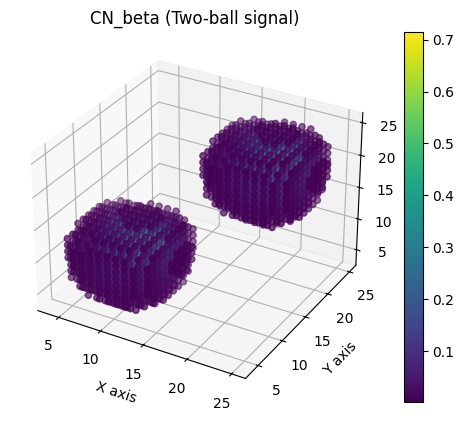

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# Assume these are dimensions of the MRI data
dim_x1, dim_x2, dim_x3 = 48, 48, 48

# Define function to create signal tensor
def create_signal_tensor(rank):
    if rank == 1:
        # One-ball signal (rank-1 decomposition)
        B1 = np.zeros((dim_x1, 1))
        B2 = np.zeros((dim_x2, 1))
        B3 = np.zeros((dim_x3, 1))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
        return B1, B2, B3
    elif rank == 2:
        # Two-ball signal (rank-2 decomposition)
        B1 = np.zeros((dim_x1, 2))
        B2 = np.zeros((dim_x2, 2))
        B3 = np.zeros((dim_x3, 2))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
            B1[15 + j, 1] = np.sin(j * np.pi / 14)
            B2[15 + j, 1] = np.sin(j * np.pi / 14)
            B3[15 + j, 1] = np.sin(j * np.pi / 14)
        return B1, B2, B3

# Function to pack the rank-1 tensor using np.tensordot
def pack_rank1_tensor(B1, B2, B3):
    return np.tensordot(np.tensordot(B1[:, 0], B2[:, 0], axes=0), B3[:, 0], axes=0)

# Function to pack the rank-2 tensor using np.tensordot
def pack_rank2_tensor(B1, B2, B3):
    tensor = np.zeros((dim_x1, dim_x2, dim_x3))
    for i in range(B1.shape[1]):  # Loop over both components (rank-2 tensor)
        tensor += np.tensordot(np.tensordot(B1[:, i], B2[:, i], axes=0), B3[:, i], axes=0)
    return tensor

# Function to plot 3D tensor using scatter plot
def plot_3d_tensor_scatter(tensor, title="3D Tensor Scatter Plot"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Prepare the grid matching the tensor dimensions
    x, y, z = np.meshgrid(np.arange(tensor.shape[0]),
                          np.arange(tensor.shape[1]),
                          np.arange(tensor.shape[2]),
                          indexing='ij')

    # Smooth the tensor values for visualization
    tensor_smoothed = gaussian_filter(tensor, sigma=1)

    # Flatten the arrays for scatter plot
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()
    values = tensor_smoothed.flatten()

    # Select points where tensor values are significant (above a threshold)
    isovalue = tensor_smoothed.mean()
    mask = values > isovalue
    x_plot = x_flat[mask]
    y_plot = y_flat[mask]
    z_plot = z_flat[mask]
    values_plot = values[mask]

    # Plot the scatter
    scatter = ax.scatter(x_plot, y_plot, z_plot, c=values_plot, cmap='viridis', marker='o')

    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(title)

    # Add color bar to indicate values
    fig.colorbar(scatter, ax=ax)

    plt.show()

# Example usage:
# Generate and pack the rank-1 tensor (one-ball signal)
B1_rank1, B2_rank1, B3_rank1 = create_signal_tensor(rank=1)
tensor_rank1 = pack_rank1_tensor(B1_rank1, B2_rank1, B3_rank1)

# Generate and pack the rank-2 tensor (two-ball signal)
B1_rank2, B2_rank2, B3_rank2 = create_signal_tensor(rank=2)
cn_beta = pack_rank2_tensor(B1_rank2, B2_rank2, B3_rank2)

# Plot the rank-2 tensor using scatter plot (two-ball signal)
plot_3d_tensor_scatter(cn_beta, title="CN_beta (Two-ball signal)")

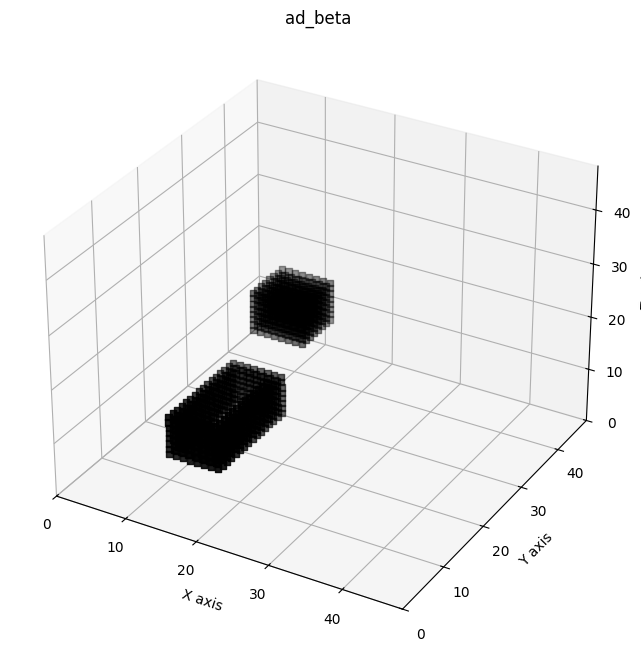

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the dimensions of the 3D grid
dim_x, dim_y, dim_z = 48, 48, 48  # Define a 48x48x48 box

# Initialize a 3D grid of zeros
ad_beta = np.zeros((dim_x, dim_y, dim_z))

# Define the size and locations of each shape

# Top-left solid square
#ad_beta[40:48, 10:18, 20:28] = 1

# Bottom-left hollow square
ad_beta[10:18, 10:26, 5:13] = 1  # Outer square
ad_beta[12:16, 12:24, 5:13] = 0  # Inner square (hollow part)

# Top-right hollow square
#ad_beta[40:48, 30:46, 35:43] = 6  # Outer square
#ad_beta[42:46, 32:44, 35:43] = 0  # Inner square (hollow part)

# Bottom-right solid square
ad_beta[10:18, 30:38, 15:23] = 6

# Plot the 3D signal
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get the coordinates of the non-zero elements
x, y, z = np.nonzero(ad_beta)

# Plot each block as a scatter point in 3D
ax.scatter(x, y, z, c='black', marker='s', s=20)  # Marker 's' makes it square

# Set labels and limits
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(0, dim_x)
ax.set_ylim(0, dim_y)
ax.set_zlim(0, dim_z)
plt.title('ad_beta')

plt.show()


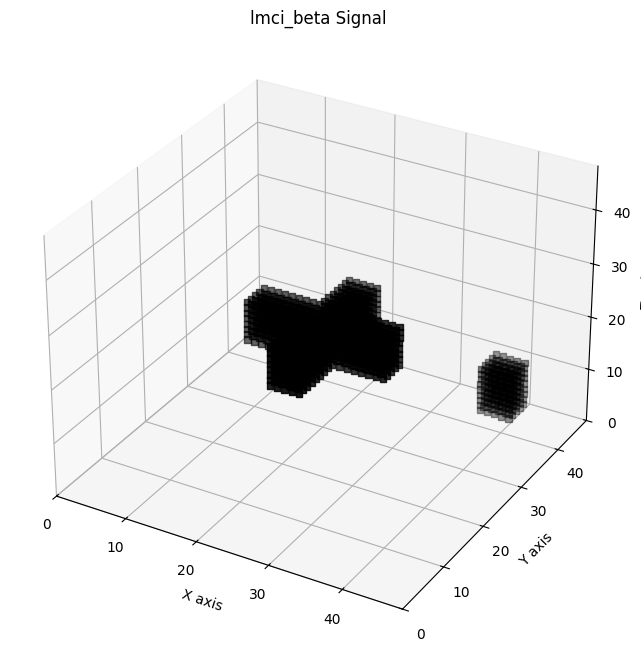

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the dimensions of the 3D grid
dim_x, dim_y, dim_z = 48, 48, 48  # Define a 48x48x48 box

# Initialize a 3D grid of zeros
lmci_beta = np.zeros((dim_x, dim_y, dim_z))

# Define the size of each block and the locations for the "plus" and corner cubes
block_size = 5  # Reduced block size to fit within 48x48x48

# Central "plus" shape in 3D (extending along x, y, and z axes)
# Horizontal bar of the plus
lmci_beta[22:22+block_size, 14:34, 20:28] = 1
# Vertical bar of the plus
lmci_beta[14:34, 22:22+block_size, 20:28] = 1

# Corner blocks
# Top-left corner
#lmci_beta[5:5+block_size, 5:5+block_size, 5:14] = 1
# Top-right corner
#lmci_beta[5:5+block_size, 38:38+block_size, 5:14] = 1
# Bottom-left corner
#lmci_beta[38:38+block_size, 5:5+block_size, 5:14] = 1
# Bottom-right corner
lmci_beta[38:38+block_size, 38:38+block_size, 5:14] = 1

# Plot the 3D signal
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get the coordinates of the non-zero elements
x, y, z = np.nonzero(lmci_beta)

# Plot each block as a scatter point in 3D
ax.scatter(x, y, z, c='black', marker='s', s=20)  # Marker 's' makes it square

# Set labels and limits
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(0, dim_x)
ax.set_ylim(0, dim_y)
ax.set_zlim(0, dim_z)
plt.title('lmci_beta Signal')

plt.show()

In [116]:
# Simulated y
import numpy as np

def response_sim(X, signal, noise_mean=0, noise_std=0.001):
    y_sim = []
    for i in range(X.shape[0]):
        # Calculate the tensordot for each sample
        response_value = np.tensordot(X[i, :, :, :], signal, axes=([0, 1, 2], [0, 1, 2]))
        y_sim.append(response_value)
    
    # Convert list to array
    y_sim = np.array(y_sim)
    
    # Add normal noise to the response
    noise = np.random.normal(loc=noise_mean, scale=noise_std, size=y_sim.shape)
    y_sim += noise
    
    return y_sim

cn_y_syn = response_sim(cn_tensor, cn_beta)
lmci_y_syn = response_sim(lmci_tensor, cn_beta)
ad_y_syn = response_sim(ad_tensor, cn_beta)

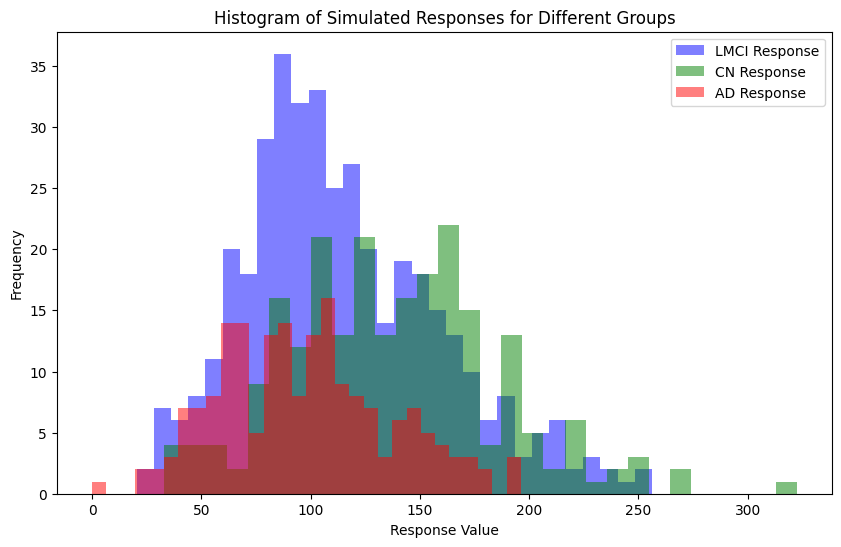

In [117]:


plt.figure(figsize=(10, 6))

# Plot each histogram with transparency to compare overlaps
plt.hist(lmci_y_syn, bins=30, alpha=0.5, label='LMCI Response', color='blue')
plt.hist(cn_y_syn, bins=30, alpha=0.5, label='CN Response', color='green')
plt.hist(ad_y_syn, bins=30, alpha=0.5, label='AD Response', color='red')

# Add labels, title, and legend
plt.xlabel('Response Value')
plt.ylabel('Frequency')
plt.title('Histogram of Simulated Responses for Different Groups')
plt.legend()

# Display the plot
plt.show()

In [73]:
X_train, X_test, y_train, y_test = train_test_split(cn_tensor, cn_y_syn, test_size=0.3, random_state=42)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=2, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .1
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(160, 48, 48, 48) (160,)
mean train RSE:  0.5055946125708478
CP train RSE:  5.767896072205094e-07
Tucker train RSE:  2.2094762817607226e-07
mean test RSE:  0.8554004858456018
CP test RSE:  0.4718797678922301
Tucker test RSE:  0.5742710227960266


In [118]:
y_variable = np.concatenate([cn_y_syn, lmci_y_syn, ad_y_syn])

# Assuming cn_tensor, lmci_tensor, and ad_tensor are 4D arrays with shape (num_samples, dim_x, dim_y, dim_z)
# Stack tensor arrays along the first axis to create image_tensor
image_tensor = np.concatenate([cn_tensor, lmci_tensor, ad_tensor], axis=0)

# Display the shapes of the resulting arrays to confirm
print("y_variable shape:", y_variable.shape)
print("image_tensor shape:", image_tensor.shape)

y_variable shape: (817,)
image_tensor shape: (817, 48, 48, 48)


In [119]:
X_train, X_test, y_train, y_test = train_test_split(image_tensor, y_variable, test_size=0.3, random_state=42)

const_array = np.load('const_list.npy', allow_pickle=True)
const_list = list(map(tuple, const_array))

print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=2, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=3, Tucker_reg_rank=3, n_mode=4, const_array=const_list)
model.sample_rate  =  .1
model.fit(X_train,y_train)

predictions = model.predict(X_train,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(571, 48, 48, 48) (571,)
mean train RSE:  0.5086106511212528
CP train RSE:  4.3303285191653695e-07
Tucker train RSE:  1.8179398941265058e-07
mean test RSE:  0.648290992690868
CP test RSE:  0.9392802319248559
Tucker test RSE:  1.1866542783768388


In [120]:
model.print_tree()

  if X[:, 12 , 7 , 12 ] <=  2.3587831341239074
   if X[:, 44 , 32 , 33 ] <=  4.440422288955204
     has  0  child nodes, and  134  samples.
   else: # if X[:, 44 , 32 , 33 ] >  4.440422288955204
     has  0  child nodes, and  118  samples.
  else: # if X[:, 12 , 7 , 12 ] >  2.3587831341239074
   if X[:, 11 , 10 , 10 ] <=  2.9517631844667056
     has  0  child nodes, and  138  samples.
   else: # if X[:, 11 , 10 , 10 ] >  2.9517631844667056
     has  0  child nodes, and  181  samples.


BTR on synthetic data

In [123]:
z = np.zeros((817, 1))
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(image_tensor, y_variable, z, test_size=0.2, random_state=42)

X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.mean
X_train_c = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
X_train_c = X_train_c + np.random.randn(*X_train_c.shape) * 1e-3
# X_train = X_train + np.random.randn(*X_train.shape) * 1e-4
nsweep = 4000
rank = 3
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing
out = tensor_reg(z_train=z_train.reshape(len(z_train),1), x_train = X_train_c, y_train = y_train, nsweep = nsweep, rank = rank, burn = burn, nskip = nskip, scale=True, a_lam= None, b_lam=None, phi_alpha=None, plot=True)

# Compute Beta_mcmc
Beta_mcmc = getBeta_mcmc(out['beta_store'])
# Compute Beta_est
p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]

Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

err = 0
for i in range(X_train.shape[0]):
    err += (np.tensordot(X_train_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_train[i])**2
mse = err/X_train_c.shape[0]
rmse = mse/np.var(y_train)
print("training RMSE:", rmse)
err = 0
for i in range(X_test.shape[0]):
    err += (np.tensordot(X_test_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_train[i])**2
mse = err/X_test_c.shape[0]
rmse = mse/np.var(y_test)
print("testing RMSE:", rmse)

Time out: 990.3164801597595
training RMSE: 0.07398693008559984
testing RMSE: 1.7958325712079415


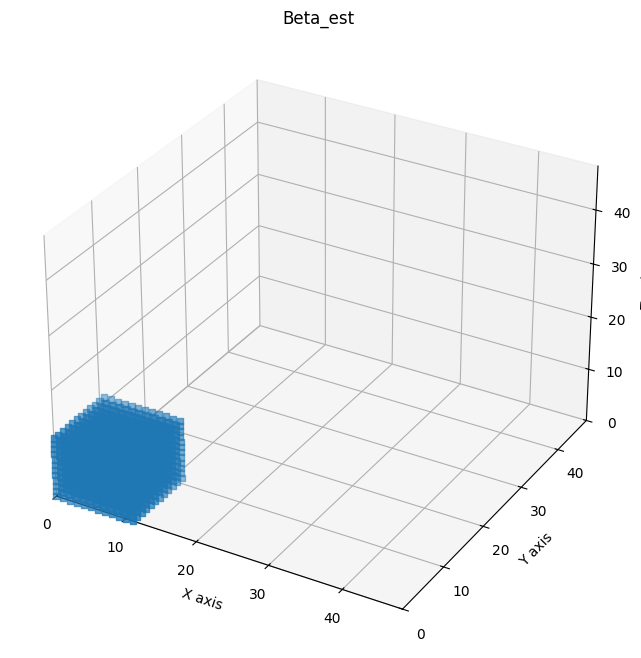

In [139]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get the coordinates of the non-zero elements
x, y, z = np.nonzero(Beta_est)

# Plot each block as a scatter point in 3D
ax.scatter(x, y, z, marker='s', s=20)  # Marker 's' makes it square

# Set labels and limits
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(0, dim_x)
ax.set_ylim(0, dim_y)
ax.set_zlim(0, dim_z)
plt.title('Beta_est')

plt.show()

In [126]:
import numpy as np

# Assuming X_train, X_test, y_train, and y_test are predefined arrays
# Initialize separate lists for each node's training and testing indices
train_indices_node1 = []
train_indices_node2 = []
train_indices_node3 = []
train_indices_node4 = []

test_indices_node1 = []
test_indices_node2 = []
test_indices_node3 = []
test_indices_node4 = []

# Separate the training data based on conditions
for i in range(X_train.shape[0]):
    if X_train[i, 12, 7, 12] <= 2.3587831341239074:
        if X_train[i, 44, 32, 33] <= 4.440422288955204:
            # Node 1
            train_indices_node1.append(i)
        else:
            # Node 2
            train_indices_node2.append(i)
    else:
        if X_train[i, 11, 10, 10] <= 2.9517631844667056:
            # Node 3
            train_indices_node3.append(i)
        else:
            # Node 4
            train_indices_node4.append(i)

# Separate the testing data based on the same conditions
for i in range(X_test.shape[0]):
    if X_test[i, 12, 7, 12] <= 2.3587831341239074:
        if X_test[i, 44, 32, 33] <= 4.440422288955204:
            # Node 1
            test_indices_node1.append(i)
        else:
            # Node 2
            test_indices_node2.append(i)
    else:
        if X_test[i, 11, 10, 10] <= 2.9517631844667056:
            # Node 3
            test_indices_node3.append(i)
        else:
            # Node 4
            test_indices_node4.append(i)

# Filter X_train and X_test data based on indices for each node
X_train_node1 = X_train[train_indices_node1]
X_train_node2 = X_train[train_indices_node2]
X_train_node3 = X_train[train_indices_node3]
X_train_node4 = X_train[train_indices_node4]

X_test_node1 = X_test[test_indices_node1]
X_test_node2 = X_test[test_indices_node2]
X_test_node3 = X_test[test_indices_node3]
X_test_node4 = X_test[test_indices_node4]

# Filter y_train and y_test data based on indices for each node
y_train_node1 = y_train[train_indices_node1]
y_train_node2 = y_train[train_indices_node2]
y_train_node3 = y_train[train_indices_node3]
y_train_node4 = y_train[train_indices_node4]

y_test_node1 = y_test[test_indices_node1]
y_test_node2 = y_test[test_indices_node2]
y_test_node3 = y_test[test_indices_node3]
y_test_node4 = y_test[test_indices_node4]

# Display the shapes of the filtered datasets for each node
print("Filtered X_train shape for Node 1:", X_train_node1.shape)
print("Filtered X_train shape for Node 2:", X_train_node2.shape)
print("Filtered X_train shape for Node 3:", X_train_node3.shape)
print("Filtered X_train shape for Node 4:", X_train_node4.shape)

print("Filtered X_test shape for Node 1:", X_test_node1.shape)
print("Filtered X_test shape for Node 2:", X_test_node2.shape)
print("Filtered X_test shape for Node 3:", X_test_node3.shape)
print("Filtered X_test shape for Node 4:", X_test_node4.shape)

print("Filtered y_train shape for Node 1:", y_train_node1.shape)
print("Filtered y_train shape for Node 2:", y_train_node2.shape)
print("Filtered y_train shape for Node 3:", y_train_node3.shape)
print("Filtered y_train shape for Node 4:", y_train_node4.shape)

print("Filtered y_test shape for Node 1:", y_test_node1.shape)
print("Filtered y_test shape for Node 2:", y_test_node2.shape)
print("Filtered y_test shape for Node 3:", y_test_node3.shape)
print("Filtered y_test shape for Node 4:", y_test_node4.shape)


Filtered X_train shape for Node 1: (150, 48, 48, 48)
Filtered X_train shape for Node 2: (138, 48, 48, 48)
Filtered X_train shape for Node 3: (161, 48, 48, 48)
Filtered X_train shape for Node 4: (204, 48, 48, 48)
Filtered X_test shape for Node 1: (25, 48, 48, 48)
Filtered X_test shape for Node 2: (41, 48, 48, 48)
Filtered X_test shape for Node 3: (47, 48, 48, 48)
Filtered X_test shape for Node 4: (51, 48, 48, 48)
Filtered y_train shape for Node 1: (150,)
Filtered y_train shape for Node 2: (138,)
Filtered y_train shape for Node 3: (161,)
Filtered y_train shape for Node 4: (204,)
Filtered y_test shape for Node 1: (25,)
Filtered y_test shape for Node 2: (41,)
Filtered y_test shape for Node 3: (47,)
Filtered y_test shape for Node 4: (51,)


In [130]:
z_train = np.zeros(X_train_node1.shape[0])

X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.mean
X_train_c = block_reduce(X_train_node1,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test_node1,block_size=X_coarsen_shape, func=X_coarsen_func)
X_train_c = X_train_c + np.random.randn(*X_train_c.shape) * 1e-3
# X_train = X_train + np.random.randn(*X_train.shape) * 1e-4
nsweep = 4000
rank = 3
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing
out = tensor_reg(z_train=z_train.reshape(len(z_train),1), x_train = X_train_c, y_train = y_train_node1, nsweep = nsweep, rank = rank, burn = burn, nskip = nskip, scale=True, a_lam= None, b_lam=None, phi_alpha=None, plot=True)

# Compute Beta_mcmc
Beta_mcmc = getBeta_mcmc(out['beta_store'])
# Compute Beta_est
p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]

Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

err = 0
for i in range(X_train_c.shape[0]):
    err += (np.tensordot(X_train_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_train_node1[i])**2
mse = err/X_train_c.shape[0]
rmse = mse/np.var(y_train_node1)
print("training RMSE:", rmse)
err = 0
for i in range(X_test_c.shape[0]):
    err += (np.tensordot(X_test_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_test_node1[i])**2
mse = err/X_test_c.shape[0]
rmse = mse/np.var(y_test_node1)
print("testing RMSE:", rmse)

Time out: 417.56024289131165
training RMSE: 0.1627110632096661
testing RMSE: 0.14620634702434357


Time out: 417.5154402256012
training RMSE: 0.14034507787468994
testing RMSE: 0.14452620527380616


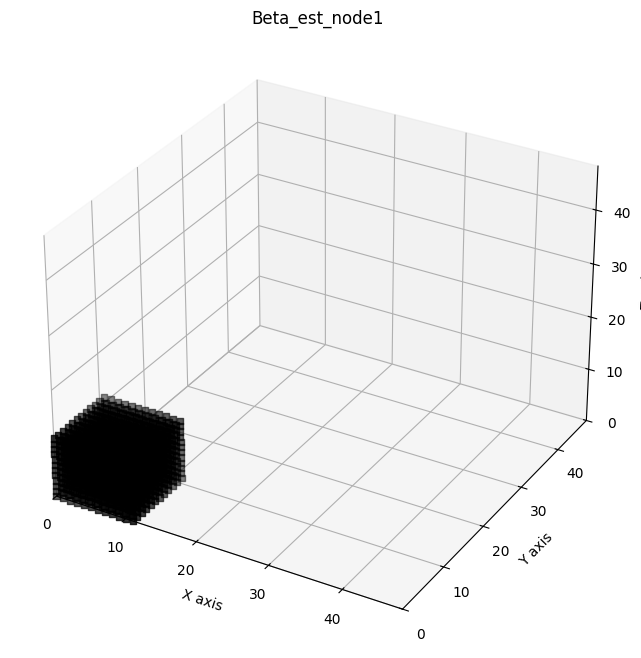

In [137]:
z_train = np.zeros(X_train_node1.shape[0])

X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.mean
X_train_c = block_reduce(X_train_node1,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test_node1,block_size=X_coarsen_shape, func=X_coarsen_func)
X_train_c = X_train_c + np.random.randn(*X_train_c.shape) * 1e-3
# X_train = X_train + np.random.randn(*X_train.shape) * 1e-4
nsweep = 4000
rank = 3
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing
out = tensor_reg(z_train=z_train.reshape(len(z_train),1), x_train = X_train_c, y_train = y_train_node1, nsweep = nsweep, rank = rank, burn = burn, nskip = nskip, scale=True, a_lam= None, b_lam=None, phi_alpha=None, plot=True)

# Compute Beta_mcmc
Beta_mcmc = getBeta_mcmc(out['beta_store'])
# Compute Beta_est
p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]

Beta_est_node1 = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

err = 0
for i in range(X_train_c.shape[0]):
    err += (np.tensordot(X_train_c[i], Beta_est_node1, axes=((0, 1, 2), (0, 1, 2)))-y_train_node1[i])**2
mse = err/X_train_c.shape[0]
rmse = mse/np.var(y_train_node1)
print("training RMSE:", rmse)
err = 0
for i in range(X_test_c.shape[0]):
    err += (np.tensordot(X_test_c[i], Beta_est_node1, axes=((0, 1, 2), (0, 1, 2)))-y_test_node1[i])**2
mse = err/X_test_c.shape[0]
rmse = mse/np.var(y_test_node1)
print("testing RMSE:", rmse)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get the coordinates of the non-zero elements
x, y, z = np.nonzero(Beta_est_node1)

# Plot each block as a scatter point in 3D
ax.scatter(x, y, z, c='black', marker='s', s=20)  # Marker 's' makes it square

# Set labels and limits
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(0, dim_x)
ax.set_ylim(0, dim_y)
ax.set_zlim(0, dim_z)
plt.title('Beta_est_node1')

plt.show()

In [131]:
z_train = np.zeros(X_train_node2.shape[0])

X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.mean
X_train_c = block_reduce(X_train_node2,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test_node2,block_size=X_coarsen_shape, func=X_coarsen_func)
X_train_c = X_train_c + np.random.randn(*X_train_c.shape) * 1e-3
# X_train = X_train + np.random.randn(*X_train.shape) * 1e-4
nsweep = 4000
rank = 3
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing
out = tensor_reg(z_train=z_train.reshape(len(z_train),1), x_train = X_train_c, y_train = y_train_node2, nsweep = nsweep, rank = rank, burn = burn, nskip = nskip, scale=True, a_lam= None, b_lam=None, phi_alpha=None, plot=True)

# Compute Beta_mcmc
Beta_mcmc = getBeta_mcmc(out['beta_store'])
# Compute Beta_est
p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]

Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

err = 0
for i in range(X_train_c.shape[0]):
    err += (np.tensordot(X_train_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_train_node2[i])**2
mse = err/X_train_c.shape[0]
rmse = mse/np.var(y_train_node2)
print("training RMSE:", rmse)
err = 0
for i in range(X_test_c.shape[0]):
    err += (np.tensordot(X_test_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_test_node2[i])**2
mse = err/X_test_c.shape[0]
rmse = mse/np.var(y_test_node2)
print("testing RMSE:", rmse)

Time out: 404.3233139514923
training RMSE: 0.09597198581059323
testing RMSE: 0.2439538343411647


In [132]:
z_train = np.zeros(X_train_node3.shape[0])

X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.mean
X_train_c = block_reduce(X_train_node3,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test_node3,block_size=X_coarsen_shape, func=X_coarsen_func)
X_train_c = X_train_c + np.random.randn(*X_train_c.shape) * 1e-3
# X_train = X_train + np.random.randn(*X_train.shape) * 1e-4
nsweep = 4000
rank = 3
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing
out = tensor_reg(z_train=z_train.reshape(len(z_train),1), x_train = X_train_c, y_train = y_train_node3, nsweep = nsweep, rank = rank, burn = burn, nskip = nskip, scale=True, a_lam= None, b_lam=None, phi_alpha=None, plot=True)

# Compute Beta_mcmc
Beta_mcmc = getBeta_mcmc(out['beta_store'])
# Compute Beta_est
p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]

Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

err = 0
for i in range(X_train_c.shape[0]):
    err += (np.tensordot(X_train_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_train_node3[i])**2
mse = err/X_train_c.shape[0]
rmse = mse/np.var(y_train_node3)
print("training RMSE:", rmse)
err = 0
for i in range(X_test_c.shape[0]):
    err += (np.tensordot(X_test_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_test_node3[i])**2
mse = err/X_test_c.shape[0]
rmse = mse/np.var(y_test_node3)
print("testing RMSE:", rmse)

Time out: 429.3075168132782
training RMSE: 0.3921993332582931
testing RMSE: 0.6048916550658885


In [133]:
z_train = np.zeros(X_train_node4.shape[0])

X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.mean
X_train_c = block_reduce(X_train_node4,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test_node4,block_size=X_coarsen_shape, func=X_coarsen_func)
X_train_c = X_train_c + np.random.randn(*X_train_c.shape) * 1e-3
# X_train = X_train + np.random.randn(*X_train.shape) * 1e-4
nsweep = 4000
rank = 3
burn = 0.3
nskip = 1
nsamp = int(np.floor((1 - burn) * nsweep / nskip))
ss = np.ceil(np.linspace(burn, 1, nsamp) * nsweep).astype(int) - 1  # adjust for 0-based indexing
out = tensor_reg(z_train=z_train.reshape(len(z_train),1), x_train = X_train_c, y_train = y_train_node4, nsweep = nsweep, rank = rank, burn = burn, nskip = nskip, scale=True, a_lam= None, b_lam=None, phi_alpha=None, plot=True)

# Compute Beta_mcmc
Beta_mcmc = getBeta_mcmc(out['beta_store'])
# Compute Beta_est
p = [out["beta_store"][0][x].shape[1] for x in range(len(out["beta_store"][0]))]

Beta_est = (out['sy'] / out['sx']) * np.mean(Beta_mcmc[ss, :], axis=0).reshape(p)

err = 0
for i in range(X_train_c.shape[0]):
    err += (np.tensordot(X_train_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_train_node4[i])**2
mse = err/X_train_c.shape[0]
rmse = mse/np.var(y_train_node4)
print("training RMSE:", rmse)
err = 0
for i in range(X_test_c.shape[0]):
    err += (np.tensordot(X_test_c[i], Beta_est, axes=((0, 1, 2), (0, 1, 2)))-y_test_node4[i])**2
mse = err/X_test_c.shape[0]
rmse = mse/np.var(y_test_node4)
print("testing RMSE:", rmse)

Time out: 479.84470796585083
training RMSE: 0.07885898096298959
testing RMSE: 0.11429245917516548


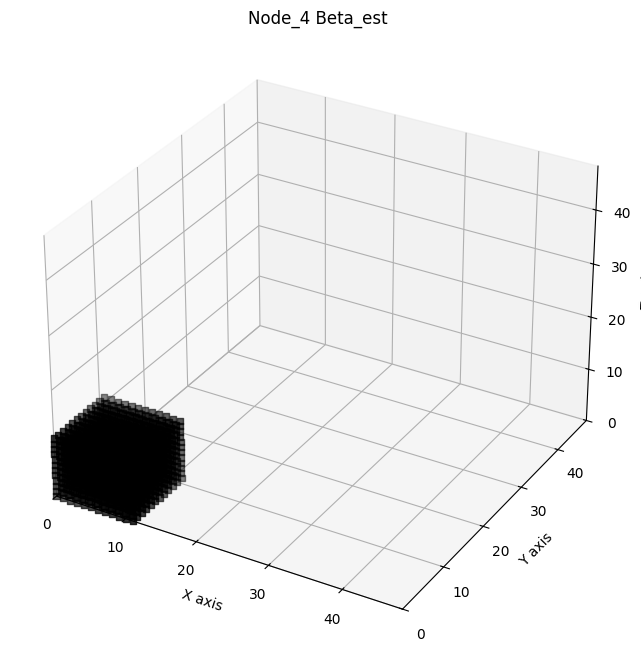

In [134]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get the coordinates of the non-zero elements
x, y, z = np.nonzero(Beta_est)

# Plot each block as a scatter point in 3D
ax.scatter(x, y, z, c='black', marker='s', s=20)  # Marker 's' makes it square

# Set labels and limits
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(0, dim_x)
ax.set_ylim(0, dim_y)
ax.set_zlim(0, dim_z)
plt.title('Node_4 Beta_est')

plt.show()